In [1]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


I will start with the easy web scraper like pd-reader. I think at the end I will try the websocket to do the scraper from trading view.

In [35]:
def compare():
    # import libraries
    import numpy as np
    import pandas as pd
    from pandas_datareader import data
    import matplotlib.pyplot as plt
    %matplotlib inline
    from cycler import cycler
    import seaborn as sns
    import random

    # input
    print('Please search the name of the asset in https://finance.yahoo.com/ first!')
    print('Which asset do you want to check for the performance (e.g. BTC-USD TSLA (max = 8 assets)):')
    a = input().split()
    b = []
    for i in a:
        b.append(i)
    print('start date (e.g. 2022/04/04):')
    x = input()
    print('end date:')
    y = input()

# When developing, I used this code to not input the data everytime.
# a = 'BTC-USD FB ETH-USD'
# a = a.split()
# b = []
# for i in a:
#     b.append(i)
# x = '2020-1-1'
# y = '2022-4-4'

    asset = data.DataReader(a, 'yahoo', start=x, end=y)
    asset.head()

    asset_close = asset['Adj Close']
    asset_num = len(asset_close.columns)
    day = len(asset_close)

    asset_return = asset_close.pct_change()
    asset_return = asset_return.dropna()
    asset_cum_return = asset_return.apply(lambda x: ((x + 1).cumprod() - 1))
    # asset_cum_return = asset_return.apply(lambda x: np.log(1+x)) #mathematic issues??

    plt.rc('axes', prop_cycle=(cycler('color', ['red', 'green', 'blue', 'pink', 'orange','#D95319','#77AC30','#4DBEEE',[0.75, 0.75, 0],[0.6350, 0.0780, 0.1840]])))

    std_figure_size = (10, 10)
    fig, ax = plt.subplots()
    for name in asset_close.columns:
        ax.plot(asset_close.index,asset_close[name], label = name)
    plt.legend()
    fig.suptitle('Asset Price (linear sclae)')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.show()
    
    #Return
    asset_mean_ret = np.mean(asset_return)
    total_ret = asset_cum_return.iloc[-1]

    # volatility
    length = len(asset_close)
    asset_vol = asset_cum_return.std().apply(lambda x: x*np.sqrt(length))
    print('volatilty:', asset_vol)
    print('')

    print('return-risk-ratio')
    for name in asset_close.columns:
        print(name, total_ret[name]/asset_vol[name])

    print('')

    # max draw down
    max_drawn = []
    for name in asset_close.columns:
        index = (1+asset_return[name]).cumprod()
        maxx = index.cummax()
        drawdown = index/maxx - 1.0
        max_draw = drawdown.cummin()
        max_drawn.append(max_draw)
    print('maximum drawn down:', max_drawn)
    print('')

def port():
    import numpy as np
    import pandas as pd
    from pandas_datareader import data
    import matplotlib.pyplot as plt
    %matplotlib inline
    from cycler import cycler
    import seaborn as sns
    import random
    import itertools

    print('Please search the name of the asset in https://finance.yahoo.com/ first!')
    print('Which asset do you want to check for the performance (e.g. BTC-USD TSLA (max = 8 assets)):')
    a = input().split()
    b = []
    for i in a:
        b.append(i)
    print('start date (e.g. 2022/04/04):')
    x = input()
    print('end date:')
    y = input()

# When developing, I used this code to not input the data everytime.
# a = 'BTC-USD FB ETH-USD'
# a = a.split()
# b = []
# for i in a:
#     b.append(i)
# x = '2020-1-1'
# y = '2022-4-4'

    asset = data.DataReader(a, 'yahoo', start=x, end=y)
    asset.head()

    asset_close = asset['Adj Close']
    # asset_close = asset_close.set_index('Date')
    asset_num = len(asset_close.columns)
    day = len(asset_close)

    asset_return = asset_close.pct_change()
    asset_return = asset_return.dropna()
    asset_cum_return = asset_return.apply(lambda x: ((x + 1).cumprod() - 1))
    # asset_cum_return = asset_return.apply(lambda x: np.log(1+x))

    plt.rc('axes', prop_cycle=(cycler('color', ['red', 'green', 'blue', 'pink', 'orange','#D95319','#77AC30','#4DBEEE',[0.75, 0.75, 0],[0.6350, 0.0780, 0.1840]])))

    #Return
    asset_mean_ret = np.mean(asset_return)
    total_ret = asset_cum_return.iloc[-1]

    # volatility
    length = len(asset_close)
    asset_vol = asset_cum_return.std().apply(lambda x: x*np.sqrt(length))

    # portfolio analysis
    # cov_matrix = asset_return.apply(lambda x: np.log(1+x)).cov()
    cov_matrix = asset_return.cov()

    # weight generation
    def portfolio_return(w, r):
        return w.T @ r
    def portfolio_vol(w, covmat):
        return (w.T @ covmat @ w)**0.5
    
    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    grid_num = 20
    grid_width = int(100/grid_num) # this mean the grid width is 5%

    x = itertools.combinations(range(grid_num + asset_num -1), asset_num-1)
    combination = []
    for i in x:
        i = list(i)
        combination.append(i)

    grid_index = []
    for i in combination:
        grid = []
        for k in range( grid_num + asset_num -1):
            grid.append('O')
        for j in i:
            grid[j] = '/'
        grid_index.append(grid)

    grid_str = []
    for i in grid_index: #change list to str
        string = ''.join([str(item) for item in i])
        string = string.split('/')
        grid_str.append(string)

    grid_w = []
    for i in grid_str:
        inte = []
        for j in i:
            inte.append(len(j)*grid_width/100)
        grid_w.append(inte)
    p_weights = np.array(grid_w)
    
    for weights in grid_w:
        # p_weights.append(weights)
        returns = np.dot(weights, asset_mean_ret) # Returns are the product of individual expected returns   								   			   # of asset and its weights 
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
                # Portfolio Variance
        vol = np.sqrt(var) # monthly standard deviation = volrality
        p_vol.append(vol)
        
# another way to calculate vol and return of port
#     grid_w = []
#     for i in grid_str:
#         inte = []
#     for j in i:
#         inte.append(len(j)*grid_width/100)
#         grid_w.append(inte)
#     p_weights = np.array(grid_w)

#     returns = portfolio_return(p_weights,asset_return.mean())
#     p_ret = returns
#     vol = portfolio_vol(p_weights,cov_matrix)
#     p_vol = np.array(vol)
#     p_vol = list(p_vol.diagonal())


# #another way to generate weight        
#     num_portfolios = 10000
#     def Rand(start, end, num):
#         res = []
#         for j in range(num):
#             res.append(random.randint(start, end))
#         return res

#     for portfolio in range(num_portfolios):
#         weights = Rand(0,101,asset_num)
#         weights = weights/np.sum(weights)

# another way v3
#     grid_num = 20
#     grid_width = int(100/grid_num) # this mean the grid width is 5%

#     x = itertools.combinations(range(grid_num + asset_num -1), asset_num-1)

#     p_weights = []
#     for i in x:
#         weights = np.zeros((asset_num,1),float)
#         for idx,j in enumerate(i):
#             if idx == 0:
#                 weights[0] = i[0]
#             else:
#                 weights[idx] = i[idx]-i[idx-1]-1
#         weights[-1] = grid_num+asset_num-2-i[-1]
#         p_weights.append(weights.T/grid_num)

    
    data = {'Returns':p_ret, 'Volatility':p_vol}


    for counter, symbol in enumerate(asset_return.columns.tolist()):
    #print(counter, symbol)
        data[symbol] = [w[counter] for w in p_weights] # add new column for weight of each 
    portfolios  = pd.DataFrame(data)

    GMV = portfolios.iloc[portfolios['Volatility'].idxmin()]
    print('GMV portfolio:', GMV)
    print('')

    MSR = portfolios.iloc[((portfolios['Returns'])/portfolios['Volatility']).idxmax()]
    print('MSR portfolio:', MSR)

    plt.subplots(figsize=(10, 10))
    plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', color = 'blue', s=10, alpha=0.3)
    plt.scatter(GMV[1], GMV[0], color='red', marker='*', s=500, label='GMV')
    plt.scatter(MSR[1], MSR[0], color='green', marker='*', s=500, label='MSR')
    plt.title('EF graph')
    plt.legend()

    MSR_weights = MSR[2:]
    asset_return['MSRPortfolio'] = asset_return.mul(np.array(MSR_weights), axis=1).sum(axis=1)

    GMV_weights = GMV[2:]
    asset_return['GMVPortfolio'] = asset_return.iloc[:,:-1].mul(np.array(GMV_weights), axis=1).sum(axis=1)
    
# returns_df['MSR'] = returns_df['btc returns'] * MSR1['btc returns weight'] + returns_df['sp500 returns'] * MSR1['sp500 returns weight'] + returns_df['gold returns'] * MSR1['gold returns weight']

    cum_returns_df = ((1+asset_return).cumprod() - 1) * 100
    fig, ax = plt.subplots(figsize=(20,10))
    fig.suptitle('Cumulative Asset Returns')
    label_position = 'upper left'
    for name in cum_returns_df:
        ax.plot(cum_returns_df[name], label=name)
    ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Return %')
    plt.show()

Please search the name of the asset in https://finance.yahoo.com/ first!
Which asset do you want to check for the performance (e.g. BTC-USD TSLA (max = 8 assets)):


 TSLA AAPL FB TM AMGN


start date (e.g. 2022/04/04):


 2020-1-1


end date:


 2022-5-7


GMV portfolio: Returns       0.000393
Volatility    0.014521
TSLA          0.000000
AAPL          0.000000
FB            0.050000
TM            0.550000
AMGN          0.400000
Name: 32, dtype: float64

MSR portfolio: Returns       0.003995
Volatility    0.036423
TSLA          0.700000
AAPL          0.300000
FB            0.000000
TM            0.000000
AMGN          0.000000
Name: 10499, dtype: float64


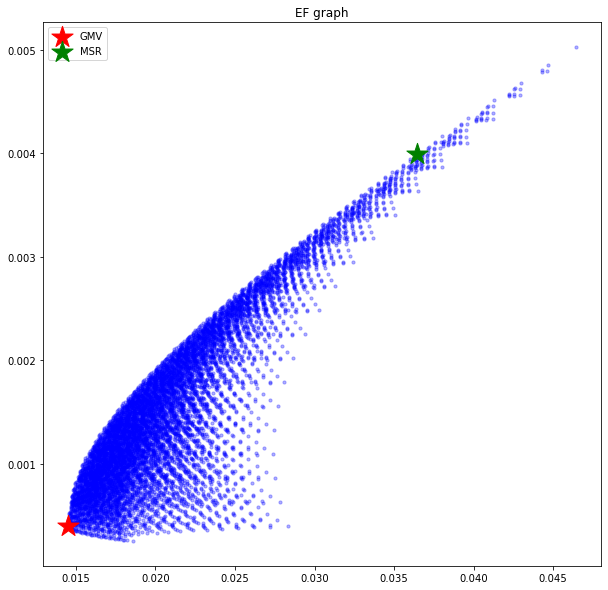

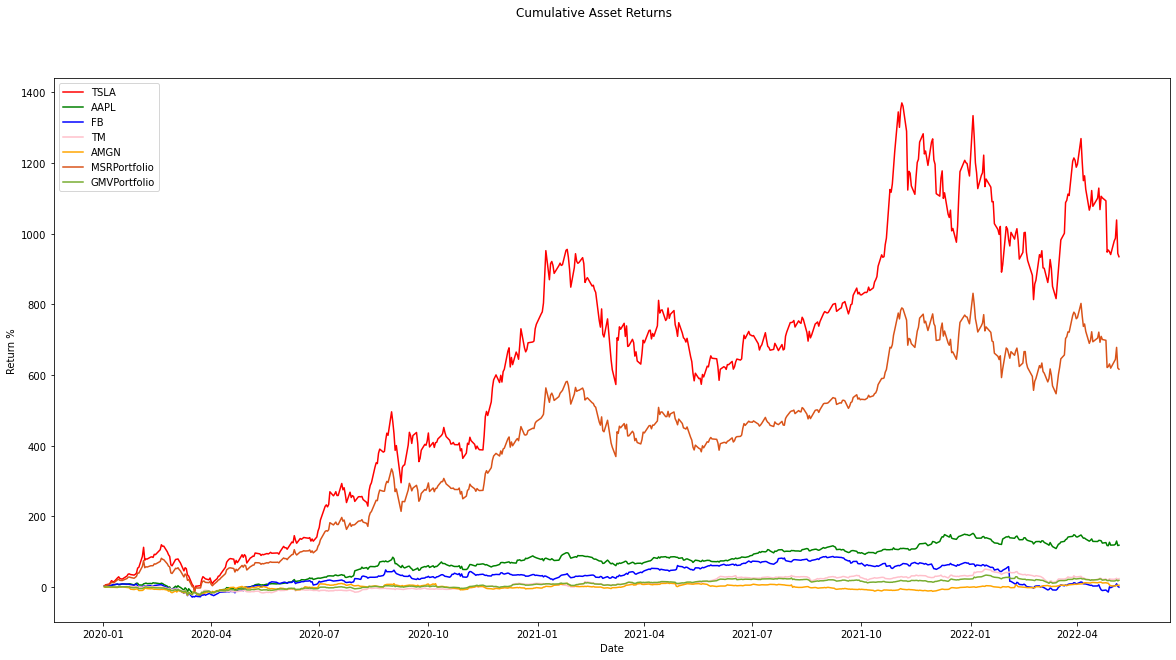

In [66]:
port()

Please search the name of the asset in https://finance.yahoo.com/ first!
Which asset do you want to check for the performance (e.g. BTC-USD TSLA (max = 8 assets)):


 BTC-USD FB ETH-USD


start date (e.g. 2022/04/04):


 2020-1-1


end date:


 2022-4-4


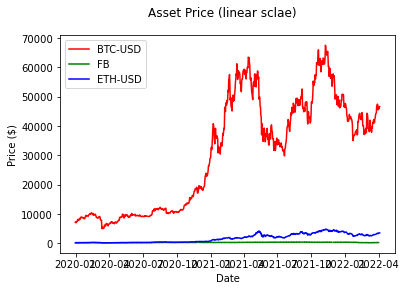

volatilty: Symbols
BTC-USD     75.742318
FB           7.981739
ETH-USD    316.943095
dtype: float64

return-risk-ratio
BTC-USD 0.07236553601243984
FB 0.017482049043101966
ETH-USD 0.0825630719845535

maximum drawn down: [Date
2020-01-01    0.000000
2020-01-02   -0.029819
2020-01-03   -0.029819
2020-01-04   -0.029819
2020-01-05   -0.029819
                ...   
2022-03-31   -0.530619
2022-04-01   -0.530619
2022-04-02   -0.530619
2022-04-03   -0.530619
2022-04-04   -0.530619
Name: BTC-USD, Length: 825, dtype: float64, Date
2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03   -0.005291
2020-01-04   -0.005291
2020-01-05   -0.005291
                ...   
2022-03-31   -0.511670
2022-04-01   -0.511670
2022-04-02   -0.511670
2022-04-03   -0.511670
2022-04-04   -0.511670
Name: FB, Length: 825, dtype: float64, Date
2020-01-01    0.000000
2020-01-02   -0.025931
2020-01-03   -0.025931
2020-01-04   -0.025931
2020-01-05   -0.025931
                ...   
2022-03-31   -0.610841
2022-04-01   -0

In [64]:
compare()